In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
exp=np.genfromtxt("expdata.txt", delimiter='\t')
amp0=np.genfromtxt("amp0.txt", delimiter='\t')
OD=np.genfromtxt("OD.txt", delimiter='\t')
constants_prob=np.genfromtxt("constants.txt", delimiter='\t')
iptg=exp[:,0][:,None]
tet0=exp[:,1][:,None]
MIC_exp=exp[:,2][:,None]
IND_exp=exp[:,3][:,None]
amp0=np.sort(amp0)[:,None]

In [3]:
def bandpass(constants_prob,iptg,tet0,amp0):
    bg_bla=constants_prob[0]*5000     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*50         #0.01 #uM combo of laci/kd_laci
    #kd_laci=constants_prob[2]*5e-3   #7.8e-4 #uM
    n_laci=constants_prob[2]*5        #2.5
    kd_iptg=constants_prob[3]*50      #25 #uM
    n_iptg=constants_prob[4]*5        #2
    #kcat=constants_prob[6]*5e6       #2.82e5 #1/m
    km=constants_prob[5]*500          #100 #uM
    ktr=constants_prob[6]*1e-2        #1e3 Combo of ktr and kcat
    MIC_int=constants_prob[7]*5       #amp[0,5]
    bg_tetc=constants_prob[8]*1000    #10/0.1 #uM/min combo of beta and gamma
    ampr=constants_prob[9]*100        #0.1/1e-2 #uM combo of ampr/kd_ampr
    n_ampr=constants_prob[10]*5       #1
    kd_amp=constants_prob[11]*0.5      #0.5 #uM
    n_amp=constants_prob[12]*5        #1
    k_tet=constants_prob[13]*10     #10
    MIC_tet_int=constants_prob[14]*5  #2
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<=amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]


    MIC_mod=np.zeros(len(iptg))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if amp[i,j]>=MIC_int:
                break
            MIC_mod[i]=amp0[j]

            
    tetc=np.zeros((len(iptg),len(amp0)))
    tet=np.zeros((len(iptg),len(amp0)))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            D_amp=1+(amp[i,j]/kd_amp)**n_amp
            D_ampr=1+(ampr/(D_amp))**n_ampr
            tetc[i,j]=bg_tetc/D_ampr
            tet[i,j]=tet0[i]*k_tet/(k_tet+tetc[i,j])

    #tet=tet0*k_tet_dif/(k_tet_dif+k_tet_act*tetc)
    MIC_tet_mod=np.zeros(len(iptg))[:,None]
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if tet[i,j]<=MIC_tet_int:
                break
            MIC_tet_mod[i]=amp0[j]
            
    modeloutput=np.zeros((len(iptg),2))
    for i in range(len(iptg)):
        modeloutput[i,0]=MIC_mod[i]
        modeloutput[i,1]=MIC_tet_mod[i]
    return modeloutput

In [4]:
high_mod=np.zeros((constants_prob.shape[0],12))
low_mod=np.zeros((constants_prob.shape[0],12))
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],iptg,tet0,amp0)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]

out=np.hstack((iptg,tet0,MIC_exp,high_mod.mean(axis=0)[:,None],IND_exp,low_mod.mean(axis=0)[:,None]))
pd.DataFrame(out,columns=['IPTG','Tet','Highpass(Exp)','Highpass(Model)','Lowpass(Exp)','Lowpass(Model)'])

,IPTG,Tet,Highpass(Exp),Highpass(Model),Lowpass(Exp),Lowpass(Model)
0,90.0,18.0,56.25,56.25,1.758,1.758000
1,180.0,18.0,225.00,225.00,3.516,3.516000
2,270.0,18.0,225.00,225.00,7.031,7.031000
3,450.0,18.0,450.00,450.00,7.031,7.031000
4,675.0,18.0,450.00,450.00,7.031,7.031000
5,900.0,18.0,450.00,450.00,7.031,7.031000
6,270.0,4.5,225.00,225.00,0.000,0.000000
7,270.0,9.0,450.00,225.00,0.000,0.000278
8,270.0,13.5,225.00,225.00,3.516,3.516000
9,270.0,18.0,225.00,225.00,7.031,7.031000


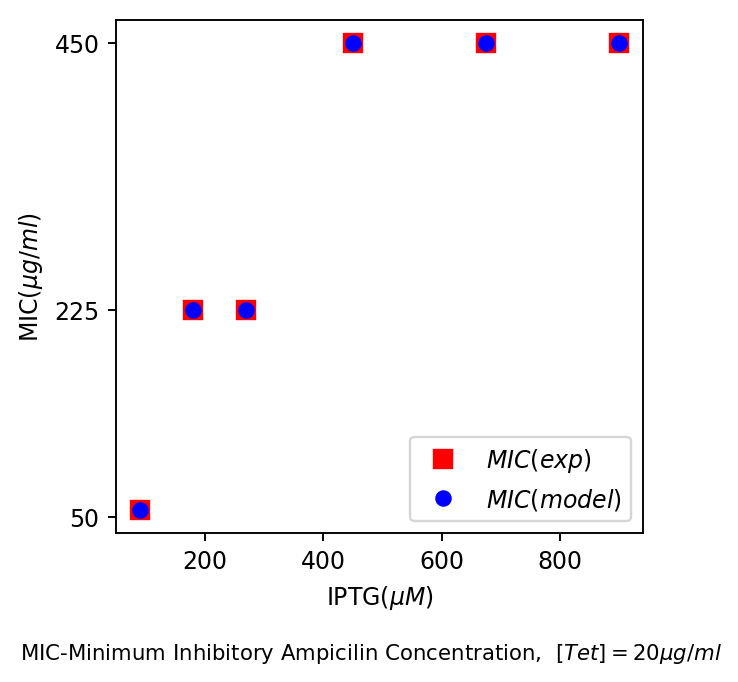

In [5]:
highpass_mean=high_mod.mean(axis=0)[:,None]
lowpass_mean=low_mod.mean(axis=0)[:,None]
fig = plt.figure(figsize=(4, 4), dpi=170)

ax1 = fig.add_subplot(111)
plt.plot(iptg[:6],MIC_exp[:6],'ro',linewidth=2.0, label='$ MIC(exp) $',marker='s',markersize=8)
plt.plot(iptg[:6],highpass_mean[:6],'bo',linewidth=2.0, label='$ MIC(model) $')
ax1.set_xlabel('IPTG($ \mu M $)')
ax1.set_ylabel('MIC($ \mu g/ml $)')
ax1.set_yticks([50,225,450])
plt.legend(loc='lower right')



txt='MIC-Minimum Inhibitory Ampicilin Concentration,  $[Tet]=20\mu g/ml$ '
fig.text(.5,-.06, txt, ha='center',fontsize=9)

plt.savefig('MIC.png',bbox_inches="tight")

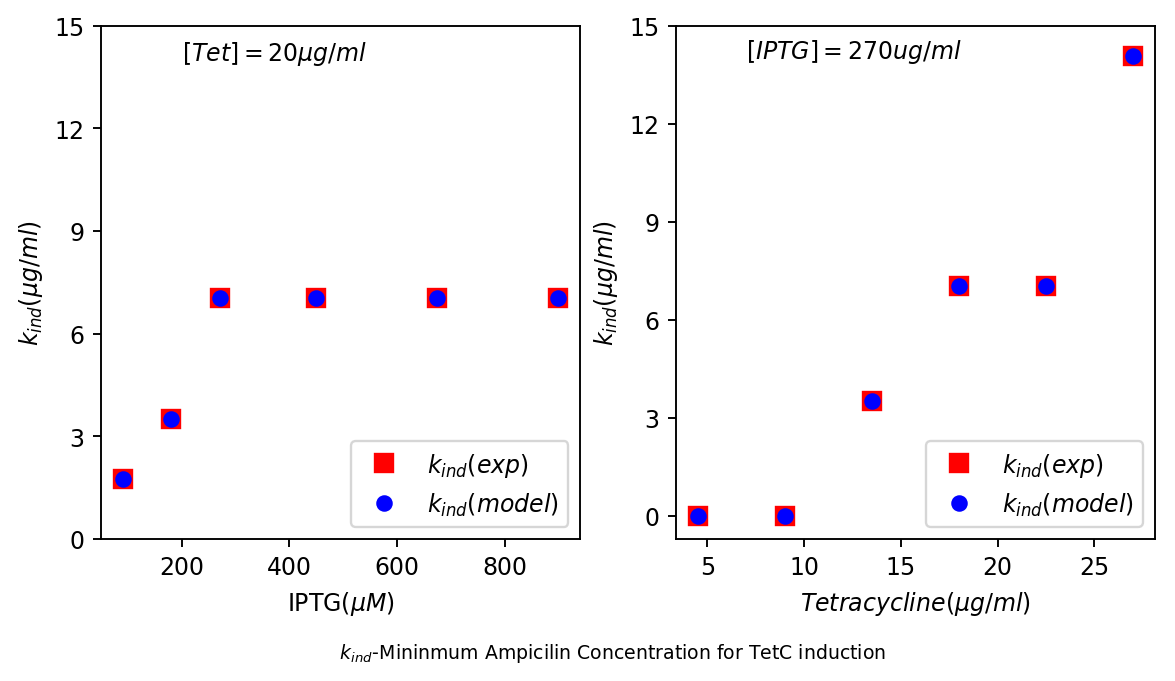

In [6]:
fig = plt.figure(figsize=(8, 4), dpi=170)
ax1 = fig.add_subplot(121)
ax1.plot(iptg[:6],IND_exp[:6],'ro',linewidth=2.0, label='$ k_{ind}(exp) $',marker='s',markersize=8)
ax1.plot(iptg[:6],lowpass_mean[:6],'bo',linewidth=2.0, label='$  k_{ind}(model) $')
ax1.set_xlabel('IPTG($ \mu M $)')
ax1.set_ylabel('$ k_{ind} ( \mu g/ml )$')
ax1.set_yticks([0,3,6,9,12,15])
ax1.text(200,14, '$[Tet]=20\mu g/ml$',horizontalalignment='left',fontsize=10)
ax1.legend(loc='lower right')
ax2 = fig.add_subplot(122)
ax2.plot(tet0[6:],IND_exp[6:],'ro',linewidth=2.0, label='$  k_{ind}(exp) $',marker='s',markersize=8)
ax2.plot(tet0[6:],lowpass_mean[6:],'bo',linewidth=2.0, label='$  k_{ind}(model) $')
ax2.set_xlabel('$Tetracycline( \mu g/ml )$')
ax2.set_ylabel('$ k_{ind} ( \mu g/ml )$')
ax2.set_yticks([0,3,6,9,12,15])
ax2.text(7,14, '$[IPTG]=270u g/ml$',horizontalalignment='left',fontsize=10)
ax2.legend(loc='lower right')
txt=' $k_{ind}$-Mininmum Ampicilin Concentration for TetC induction '
fig.text(.5,-0.05, txt, ha='center',fontsize=8)
plt.savefig('k_ind.png',bbox_inches="tight")

In [7]:
iptg_mod=np.linspace(10, 1000, num=50)[:,None]
amp0_mod=np.linspace(0.001, 600, num=50)[:,None]
high_mod=np.zeros((constants_prob.shape[0],50))
low_mod=np.zeros((constants_prob.shape[0],50))
tet0_mod=18*np.ones(50)[:,None]
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],iptg_mod,tet0_mod,amp0_mod)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]
highpass_mean=high_mod.mean(axis=0)

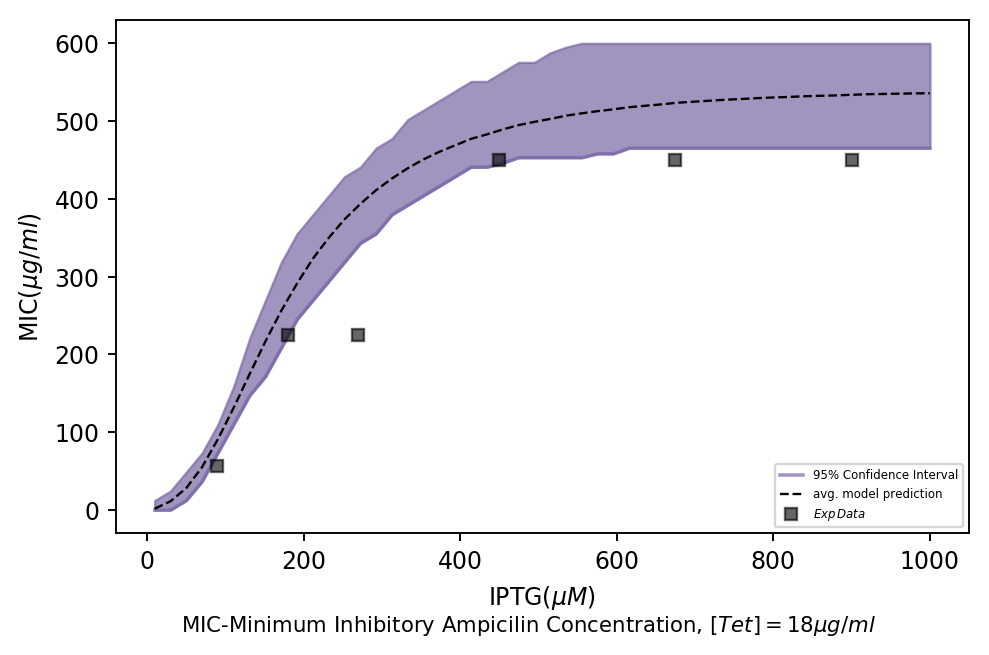

In [8]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
fig = plt.figure(figsize=(4*1.618, 4), dpi=170)
qs = mquantiles(high_mod, [0.025, 0.975], axis=0)
plt.fill_between(iptg_mod[:, 0], *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(iptg_mod[:, 0], qs[0], label="95% Confidence Interval", color="#7A68A6", alpha=0.7)

plt.plot(iptg_mod, highpass_mean, lw=1, ls="--", color="k",
         label="avg. model prediction")

plt.plot(iptg[:6],MIC_exp[:6],'ko',linewidth=2.0, label='$ Exp \, Data $',marker='s',markersize=5,alpha=0.6)
plt.xlabel('IPTG($ \mu M $)')

plt.ylabel('MIC($ \mu g/ml $)')
plt.legend(loc="lower right",fontsize=5)
txt='MIC-Minimum Inhibitory Ampicilin Concentration,\t$[Tet]=18\mu g/ml$ '
fig.text(.5,-.02, txt, ha='center',fontsize=9)

plt.savefig('MIC_CI.png',bbox_inches="tight")

In [14]:
iptg_mod=np.linspace(10, 1000, num=50)[:,None]
amp0_mod=np.linspace(0.001, 30, num=50)[:,None]
high_mod=np.zeros((constants_prob.shape[0],50))
low_mod=np.zeros((constants_prob.shape[0],50))
tet0_mod=18*np.ones(50)[:,None]
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],iptg_mod,tet0_mod,amp0_mod)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]
lowpass_iptg=low_mod
lowpass_iptg_mean=lowpass_iptg.mean(axis=0)

In [15]:
high_mod=np.zeros((constants_prob.shape[0],50))
low_mod=np.zeros((constants_prob.shape[0],50))
tet0_mod=np.linspace(0.1,30 , num=50)[:,None]
amp0_mod=np.linspace(0.001, 30, num=50)[:,None]
iptg_mod1=270*np.ones(50)[:,None]
for i in range(constants_prob.shape[0]):
    modeloutput=bandpass(constants_prob[i],iptg_mod1,tet0_mod,amp0_mod)
    high_mod[i,:]=modeloutput[:,0]
    low_mod[i,:]=modeloutput[:,1]

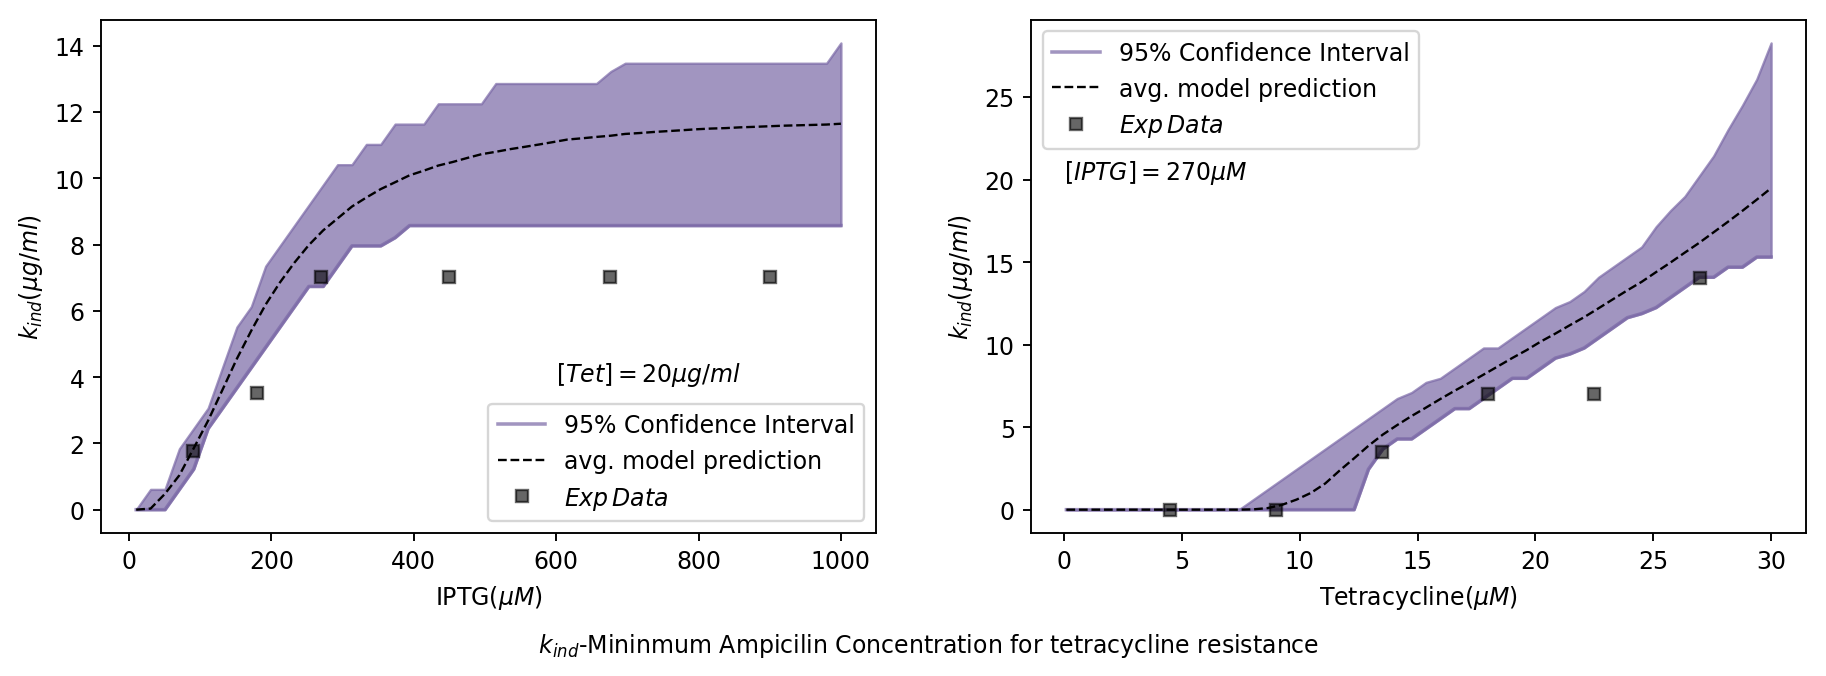

In [33]:


# vectorized bottom and top 2.5% quantiles for "confidence interval"
fig = plt.figure(figsize=(8*1.618, 4), dpi=170)

ax1 = fig.add_subplot(121)
qs = mquantiles(lowpass_iptg, [0.025, 0.975], axis=0)
ax1.fill_between(iptg_mod[:, 0], *qs, alpha=0.7,color="#7A68A6")
ax1.plot(iptg_mod[:, 0], qs[0], label="95% Confidence Interval", color="#7A68A6", alpha=0.7)
ax1.plot(iptg_mod, lowpass_iptg_mean, lw=1, ls="--", color="k",label="avg. model prediction")
ax1.plot(iptg[:6],IND_exp[:6],'ko',linewidth=2.0, label='$ Exp \, Data $',marker='s',markersize=5,alpha=0.6)
plt.xlabel('IPTG($ \mu M $)',fontsize=10)
plt.ylabel('$ k_{ind} ( \mu g/ml )$',fontsize=10)
plt.legend(loc="lower right",fontsize=10)
ax1.text(600,4.5, '$[Tet]=20\mu g/ml$',horizontalalignment='left',verticalalignment='top',fontsize=10)

ax2 = fig.add_subplot(122)
qs = mquantiles(low_mod, [0.025, 0.975], axis=0)
ax2.fill_between(tet0_mod[:, 0], *qs, alpha=0.7,color="#7A68A6")
ax2.plot(tet0_mod[:, 0], qs[0], label="95% Confidence Interval", color="#7A68A6", alpha=0.7)
ax2.plot(tet0_mod, low_mod.mean(axis=0), lw=1, ls="--", color="k",label="avg. model prediction")
ax2.plot(tet0[6:],IND_exp[6:],'ko',linewidth=2.0, label='$ Exp \, Data $',marker='s',markersize=5,alpha=0.6)
plt.xlabel('Tetracycline($ \mu M $)',fontsize=10)
plt.ylabel('$ k_{ind} ( \mu g/ml )$',fontsize=10)
plt.legend(loc="upper left",fontsize=10)
ax2.text(0,20, '$[IPTG]=270\mu M$',horizontalalignment='left',fontsize=10)

txt=' $k_{ind}$-Mininmum Ampicilin Concentration for tetracycline resistance '
fig.text(.5,-0.05, txt, ha='center',fontsize=10)

plt.savefig('k_ind_CI.png',bbox_inches="tight")

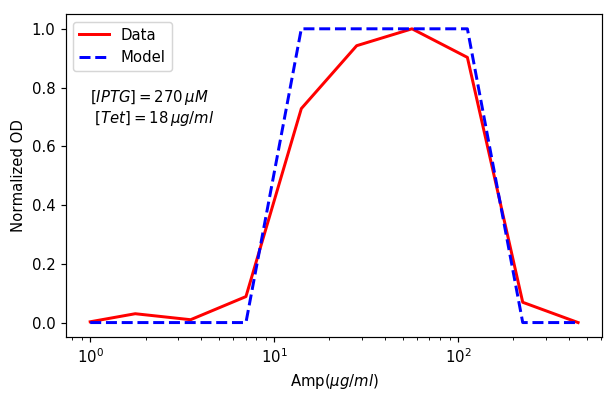

In [26]:
amp0[0]=1
high=amp0<=224
low=amp0<=7.031
OD_pred=(1-low)*high
fig = plt.figure(figsize=(4*1.618, 4), dpi=107)
plt.semilogx(amp0,OD[:,2],'r-',linewidth=2.0,label='Data')
plt.semilogx(amp0,OD_pred,'b--',linewidth=2.0,label='Model')
plt.xlabel('Amp($\mu g/ml$)')
plt.ylabel('Normalized OD')
plt.legend(loc='upper left')
plt.text(1,0.8, '$ [IPTG]=270 \, \mu M $ \n $ [Tet]=18 \, \mu g/ml $', horizontalalignment='left',va='top',fontsize=10)
plt.savefig('OD_comp.png',bbox_inches="tight")